# Data preprocessing

In [1]:
import csv
import os
import shutil
import time
#downlaod necessary libraries
# !pip install pydub
# !pip install numpy
# !pip install matplotlib
# !pip install scipy
# !pip install IPython
# !pip install librosa
# !pip install soundfile
# !pip install pandas
# !pip install ffmpeg
from pydub import AudioSegment
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import librosa
import soundfile as sf
import pandas as pd

D:\University\BLSTM-RNN-Transformer-ASR\venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Extracting relevant files

Before working on the data, it is necessary to ensure relevant data is avaialble. To train data to work better with South asian accents it is important we only get audio clips with SOuth asian accents.

Svarah is collected to be specific to India so that does not need to be sorted.

Common Voice contains data from people with diverse backgrounds. For this project, we only need data with accents tags of India and Pakistan. Voice clips that originate from South Asia are labelled as India and South Asia (India, Pakistan, Sri Lanka). For our purpose these are the only audio clips we will use. Further, to avoid empty or faulty files, only audio clips about India and South Asia mentioned in the validated  TSV file will be used. Below code extracts any audio clip of which teh label contains "pak" or "ind". Based on how Common Voice is done, this will include voice clips fro people of Sri Linkan origin as well.

In [ ]:
VALIDATED_FILE_PATH = "D:/University/cv-corpus/en/validated.tsv"
TARGET_ACCENT_PAK = "pak"
TARGET_ACCENT_IND = "ind"


# TODO: new validated file that includes only the names of the relevant pakistani and indian files and info related to them

with open(VALIDATED_FILE_PATH, newline='', encoding='utf-8') as file:
    # Create a CSV reader object, specifying the delimiter as a tab character
    reader = csv.reader(file, delimiter='\t')

    # Used to store names of all the clips that are indian or pakistani
    clipFileNames = set();
    count = 0
    # Iterate through each row in the TSV file
    for row in reader:

        # Check if the value in the 'accents' column matches the target value for the accents
        # 'accents' column is the 8th column (index 7)
        if (TARGET_ACCENT_PAK.lower() in row[7].lower()) or \
                (TARGET_ACCENT_IND.lower() in row[7].lower()):
            # Add the clip name to array (Column 2, index 1) if match is successful
            clipFileNames.add(row[1].lower())
            count = count + 1
    print(f"{count} number of files in Validated tsv")

print("\n\n")
# Define the directory path for all clips
sourceDirPath = "D:/University/cv-corpus/en/clips/"
# Get a list of all files in the directory
filesInDir = os.listdir(sourceDirPath)

# path to store data in, if doesn't exist then make one
destDirPath = "D:/University/cv-corpus/en/ind_pak_clips/"
if not os.path.exists(destDirPath):
    os.makedirs(destDirPath)

count = 0

# Find and copy clips that are pakistani or Indian
for clipName in filesInDir:
    if (clipName.lower() in clipFileNames):
        # file path of the source directory copy clips from
        VALIDATED_FILE_PATH = os.path.join(sourceDirPath + clipName)
        # directory to paste file into
        destPath = os.path.join(destDirPath + clipName)

        # when files are found, increase count
        count = count + 1
        #Copy file to a new folder: ind_pak_data
        shutil.copy2(VALIDATED_FILE_PATH, destPath)

    if (count % 1000 == 0):
        print(f"Number of files done: {count}")

print(f"Copied {count} number of files")



## Finding length of all the relevant data we can use

Once we have the relevant audio clips, we might want to know the length of total audio we have. There is a clip_duration.tsv file provided which mentions the length of all the audio clips. We can check the name of every audio we have in the clip_duration.tsv file and add up the values to calculate the total time.

In [1]:
DURATION_FILE = "D:/University/cv-corpus/en/clip_durations.tsv"
durationDict = {}

with open(DURATION_FILE, newline='', encoding='utf-8') as file:

    # Create a CSV reader object, specifying the delimiter as a tab character
    reader = csv.reader(file, delimiter='\t')
    next(reader)

    # Used to store names of all the clips that are indian or pakistani
    clipFileNames = set();

    # Iterate through each row in the TSV file to get all the names
    for row in reader:
        durationDict[row[0]] = int(row[1])

# path to the source with all the audio clips.
sourceDirPath = "D:/University/cv-corpus/en/ind_pak_clips/"
# Get a list of all files in the directory
filesInDir = os.listdir(sourceDirPath)

count = 0
msTotalTime = 0
for file in filesInDir:
    msTotalTime = msTotalTime + durationDict[file]
    count += 1

# default is in ms which we dont want
sTotalTime = msTotalTime / 1000 # seconds
mTotalTime = sTotalTime / 60 # minutes
hTotalTime = mTotalTime / 60 # hours

# Print the results
print(f"""
Number of files: {count}
ms: {msTotalTime:.0f}
sec: {sTotalTime:.0f}
mins: {mTotalTime:.0f}
hrs: {hTotalTime:.0f}
""")


FileNotFoundError: [Errno 2] No such file or directory: 'D:/University/cv-corpus/en/clip_durations.tsv'

## File Format

As the data we have in Svarah and Common Voice currently is in different formats, it is worth changing one fo them so botht he audio clips are of the same format. Below code chanegs all teh Common Vocie audio clips from mp3 to wav, same as Svarah.


In [ ]:
def convert_file(file, srcDirPath, destDirPath):
    if file.endswith(".mp3"):
        outFile = os.path.join(destDirPath, os.path.splitext(file)[0] + ".wav")
        audio = AudioSegment.from_file(os.path.join(srcDirPath, file))
        audio.set_frame_rate(16000).export(outFile, format="wav")
        # return f"Converted {file} to {outFile}"


def make_mp3(srcDirPath, destDirPath):
    files = os.listdir(srcDirPath)

    # Create destination directory if it doesn't exist
    if not os.path.exists(destDirPath):
        os.makedirs(destDirPath)

    # Using ProcessPoolExecutor to parallelize the task
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(convert_file, file, srcDirPath, destDirPath) for file in files]
        count = 0
        for future in concurrent.futures.as_completed(futures):
            future.result()
            count += 1
            if count % 1000 == 0:
                print(f"count: {count}")



start_time = time.perf_counter()

wrongFormatDir = "D:/University/Data/cv-corpus/en/ind_pak_clips_mp3"
rightFormatDir = "D:/University/Data/cv-corpus/en/ind_pak_clips_wav/"

# wrongFormatDir = "D:/University/Data/sample/mp3"
# rightFormatDir = "D:/University/Data/sample/wav"
make_mp3(wrongFormatDir, rightFormatDir)

end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code block took {elapsed_time} seconds to run.")

## Zero Crossing Rate

To reduce computation time, we can reduce total audio length by removing gaps in audio. We will use Zero Crossing rate (ZCR) to do this. ZCR is besically a measure of how often an audio signal changes from positive to negative. During silences, the ZCR rate will be high compared to low times when someone is speaking.

The code below for now is only for one file

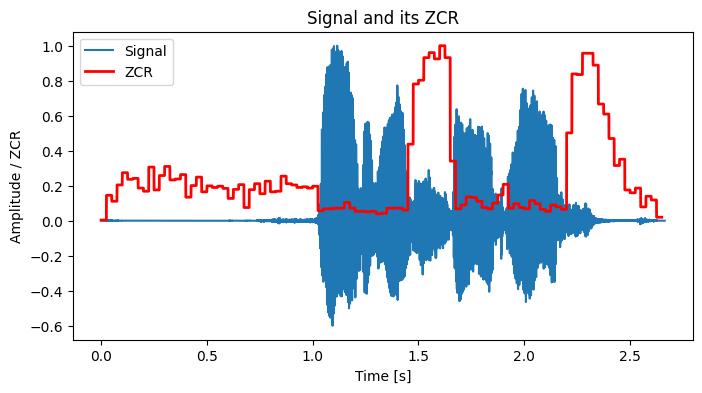

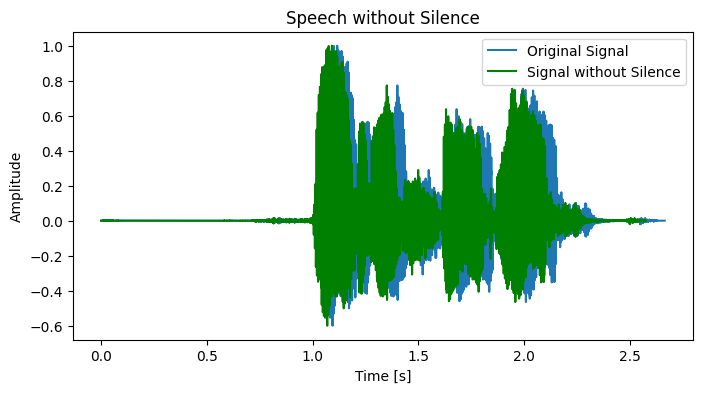

Original Audio 



After removing based on ZCR 



Modified audio saved to D:/University/Data/sample/zcr/common_voice_en_220787.wav


In [47]:
def framing(signal, frameDuration, sampleRate):
    frameLen = int(frameDuration * sampleRate)
    frames = []
    for start in range(0, len(signal), frameLen):
        frame = signal[start:start + frameLen]
        if len(frame) == frameLen:
            frames.append(frame)
    return np.array(frames)

def calculateZcr(frames):
    zcr = np.zeros(frames.shape[0])
    for i, frame in enumerate(frames):
        # Count the zero crossings
        zcr[i] = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return zcr

# Read WAV file
input_audio_file = "D:/University/Data/sample/wav/common_voice_en_220787.wav"
sampleRate, signal = wavfile.read(input_audio_file)
# Normalize the signal
signal = signal / np.abs(np.max(signal)).astype(float)

# Do framing
frameDuration = 0.025  # 25ms per frame
frames = framing(signal, frameDuration, sampleRate)

# Calculate ZCR for all frames
zcrValues = calculateZcr(frames)

# Calculate rate and normalize
zcrRate = zcrValues / frames.shape[1]
zcrRateNormalized = zcrRate / np.max(zcrRate)

# Create a ZCR waveform for plotting
zcrWave = np.repeat(zcrRateNormalized, frames.shape[1])

# Plot the ZCR with Signal
t = np.linspace(0, len(signal) / sampleRate, len(signal))
t1 = np.linspace(0, len(zcrWave) / sampleRate, len(zcrWave))

plt.figure(figsize=(8, 4))
plt.plot(t, signal, label='Signal')
plt.plot(t1, zcrWave, 'r', linewidth=2, label='ZCR')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude / ZCR')
plt.legend()
plt.title('Signal and its ZCR')
plt.show()

# Silence Removal
silenceThreshold = 0.04

nonSilenceIndices = zcrRateNormalized > silenceThreshold
framesWithoutSilence = frames[nonSilenceIndices]

# Reconstruct signal from frames without silence
dataReconstructed = np.hstack(framesWithoutSilence)
# calculate time in seconds properly
tReconstructed = np.arange(len(dataReconstructed)) / sampleRate


plt.figure(figsize=(8, 4))
plt.plot(t, signal, label='Original Signal')
plt.plot(tReconstructed, dataReconstructed, 'g', label='Signal without Silence')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Speech without Silence')
plt.show()

# Save the modified signal to a WAV file
output_audio_filePath = 'D:/University/Data/sample/zcr/common_voice_en_220787.wav'
wavfile.write(output_audio_filePath, sample_rate, dataReconstructed.astype(np.float32))


print(f"Original Audio \n")
display(Audio(input_audio_file))
print(f"After removing based on ZCR \n")
display(Audio(output_audio_filePath))
print(f"Modified audio saved to {output_audio_filePath}")

## Removing leading and trailing silence

Continuing from the last part, most of the audios have empty sound before and after speech. We cane easily remove by very low volume audios from the file. For this, we are taking the route of checking for the sound decibels.

For now, the below code only does it for one audio file.

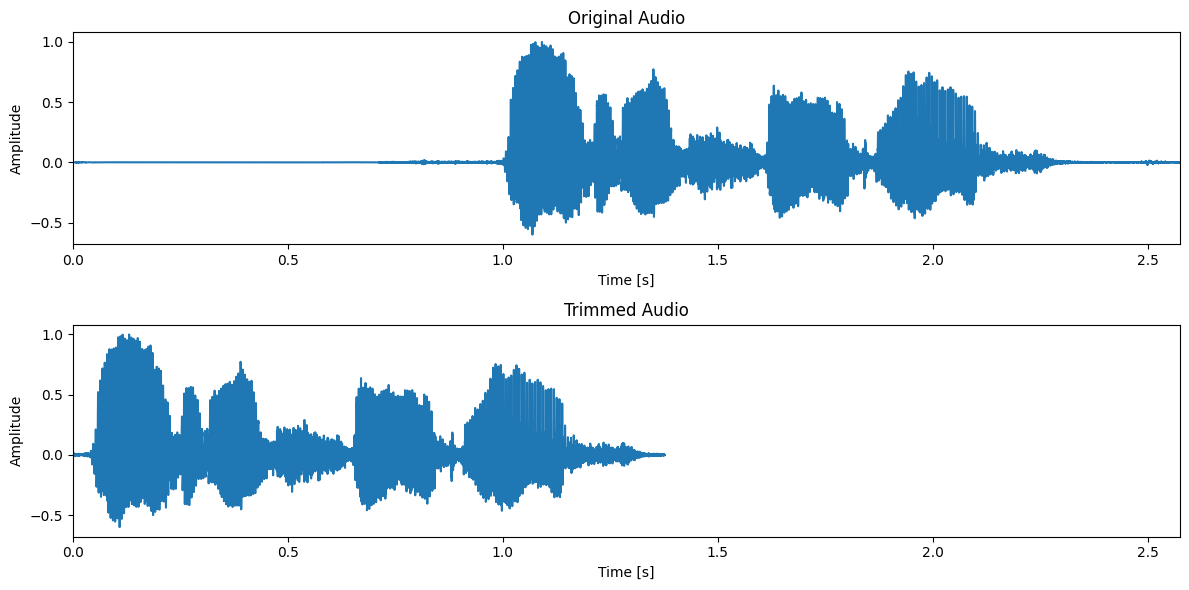

In [48]:
# Load audio file
audio, sr = librosa.load("D:/University/Data/sample/zcr/common_voice_en_220787.wav", sr=None)

# Time axis for the original audio
tOriginal = np.linspace(0, len(audio) / sr, num=len(audio))


#Duration of the original audio
maxDuration = len(audio) / sr

# Trim silence
trimmedAudio, _ = librosa.effects.trim(audio, top_db=30)  # top_db is the threshold for silence

# Create a time axis for the trimmed audio
tTrimmed = np.linspace(0, len(trimmedAudio) / sr, num=len(trimmedAudio))

# Save the trimmed audio
sf.write("D:/University/Data/sample/trimmed/common_voice_en_220787.wav", trimmedAudio, sr)

# Plot the original and trimmed audio signals
plt.figure(figsize=(12, 6))

# Plot original audio
plt.subplot(2, 1, 1)
plt.plot(tOriginal, audio)
plt.title('Original Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0, maxDuration])  # Ensure the x-axis is the same for both plots


# Plot trimmed audio
plt.subplot(2, 1, 2)
plt.plot(tTrimmed, trimmedAudio)
plt.title('Trimmed Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0, maxDuration])  # Ensure the x-axis is the same for both plots


plt.tight_layout()
plt.show()


For visualizing distribution of Common voice


Distinct accent labelled recordings based on validated.tsv: 949449
accents
United States English    418581
England English          144884
South Asia               106332
Canadian English          69278
Australian English        53475
German English            48665
Scottish English          17321
Southern Africa           15177
New Zealand English       13443
Irish English             10123
Other                     52170
Name: count, dtype: int64
Actual line count in TSV file: 1752390
Number of unlabelled recordings: 802941


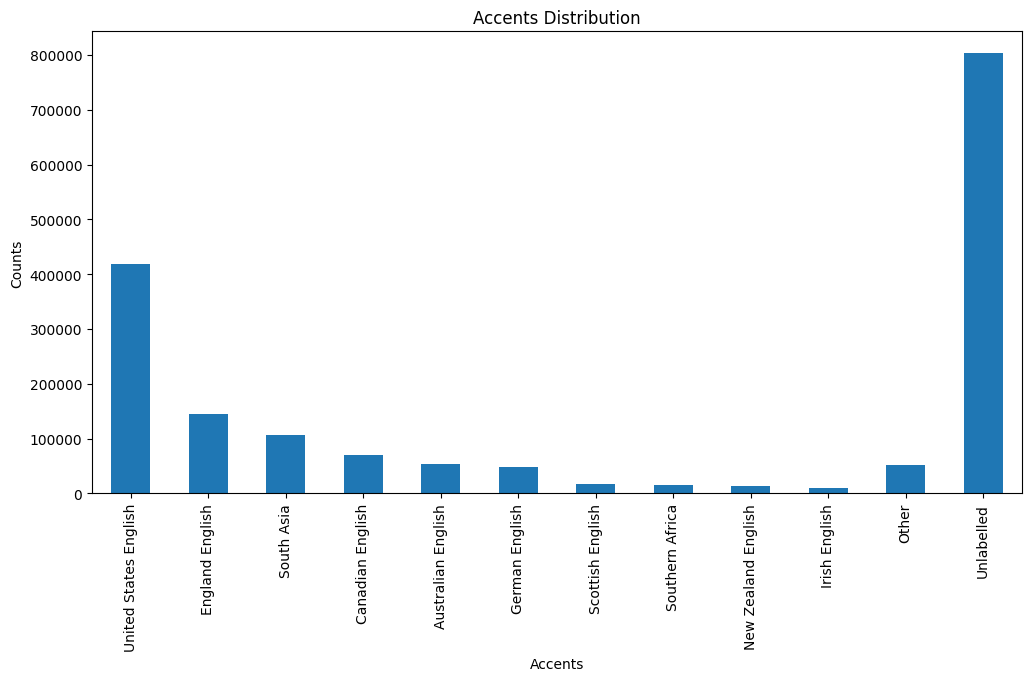

Labelled data Skewness: 2.119762051557477
Labelled data Kurtosis: 3.234058845978905


In [49]:
from scipy.stats import skew, kurtosis

# Load the dataset
df = pd.read_csv('D:/University/Data/cv-corpus/en/validated.tsv', sep='\t')

# Group by the 'accent' column and count
accent_counts = df['accents'].value_counts()


# Create a copy for graph representation
accent_counts_for_graph = accent_counts.copy()

# Define renaming dictionary for long accent names
rename_dict = {
    'India and South Asia (India, Pakistan, Sri Lanka)': 'South Asia',
    'Southern African (South Africa, Zimbabwe, Namibia)': 'Southern Africa',
    'German English,Non native speaker': 'German English'
}

# Rename in the copy for graph
accent_counts_for_graph.rename(index=rename_dict, inplace=True)

# Select the top 10 accents and sum the rest as 'Other'
top_accents = accent_counts_for_graph.head(10)
top_accents['Other'] = accent_counts_for_graph[10:].sum()


# Count the actual number of lines in the file which should be the total number of accents
with open('D:/University/Data/cv-corpus/en/validated.tsv', 'r', encoding='utf-8') as file:
    line_count = sum(1 for line in file)
    line_count -= 1 # To discount the header

print(f"Distinct accent labelled recordings based on validated.tsv: {accent_counts.sum()}\n{top_accents}")
print(f"Actual line count in TSV file: {line_count}")

# Calculate the number of data that is unlabelled
top_accents['Unlabelled'] = line_count - accent_counts.sum()

print(f"Number of unlabelled recordings: {top_accents['Unlabelled']}")

# Plot the modified data
plt.figure(figsize=(12, 6))
top_accents.plot(kind='bar')
plt.title('Accents Distribution') # (Modified for Representation)
plt.xlabel('Accents')
plt.ylabel('Counts')
plt.show()

# Calculate and display skewness and kurtosis for the modified data
accent_skewness = skew(top_accents)
accent_kurtosis = kurtosis(top_accents)

print(f"Labelled data Skewness: {accent_skewness}")
print(f"Labelled data Kurtosis: {accent_kurtosis}")


## MFCC feature extraction

Extract MFCC features for the audio.

Steps for MFCC feature extraction
1. extract MFCCs
2. calculate MFCC delta (First derivative)
3. calculate MFCC delta delta (Second derivative)
4. calculate energy features (for MFCC, delta and delta delta)
5. CMVN normalization

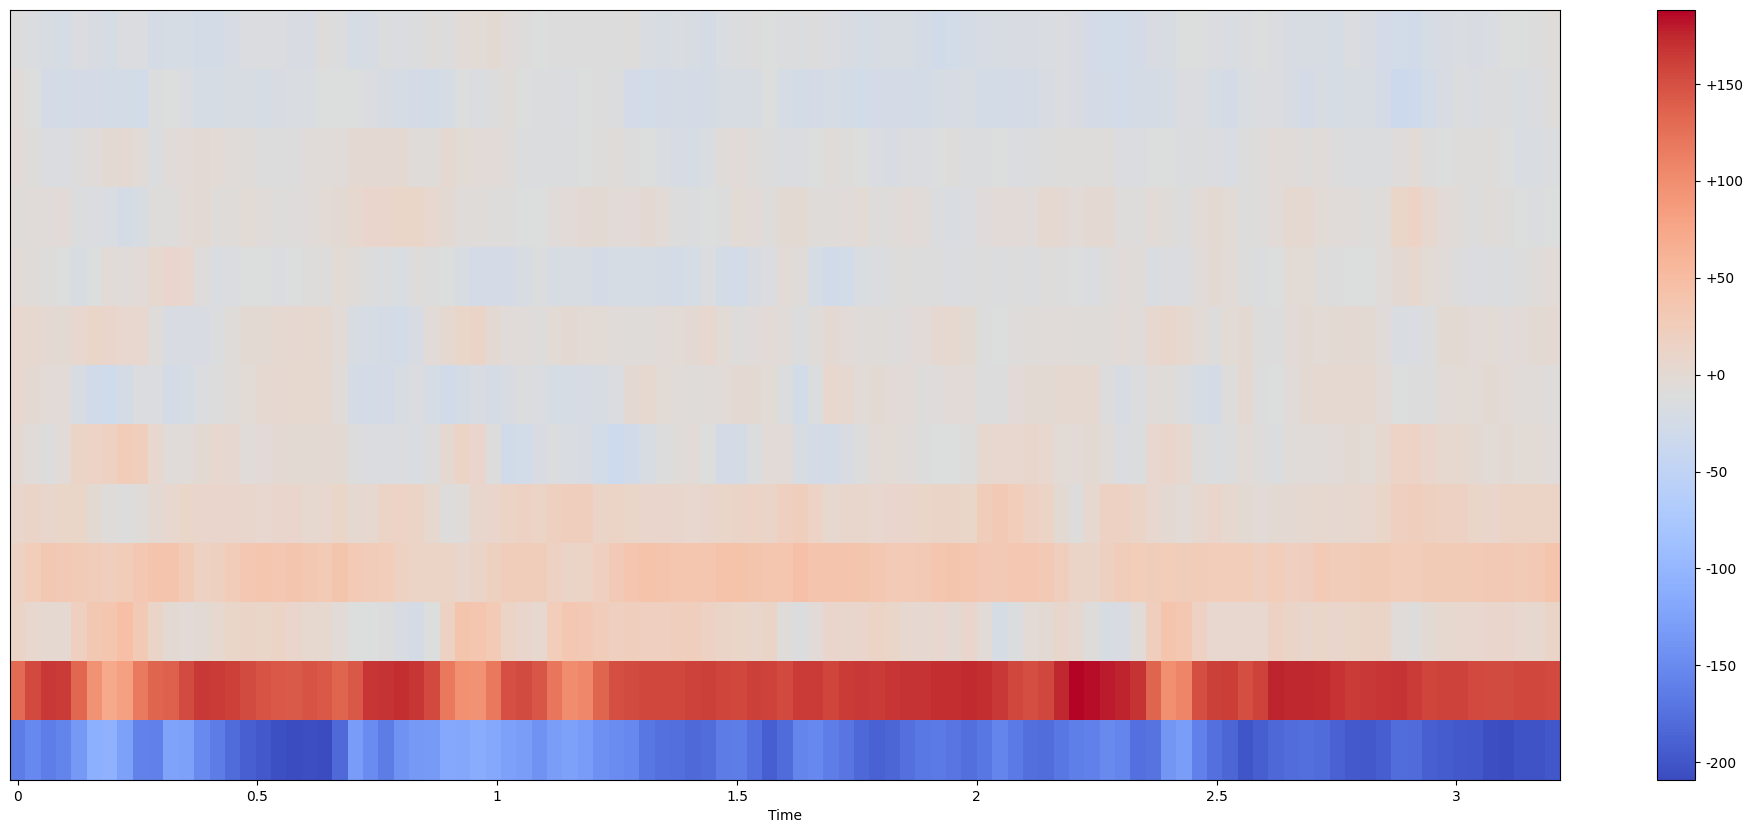

(39, 101)

In [22]:
import librosa.display
import IPython.display as  ipd

# Load audio file
audio_file = "D:/University/Data/sample/trimmed/281474976879627_f1171_chunk_0.wav"

# load with librosa
signal, sr = librosa.load(audio_file, sr=None)

# Extract MFCC using librosa
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

#check mfcc shape
mfccs.shape

#Visualize MFCCs

plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)

plt.colorbar(format="%+2.f")
plt.show()

# Compute first and second MFCC derivatives

delta_mfccs = librosa.feature.delta(mfccs)

delta2_mfccs = librosa.feature.delta(mfccs, order=2)

delta_mfccs.shape
delta2_mfccs.shape

# concatenate the MFCCs with first and second derivative

mfccs_features = np.concatenate((mfccs,delta_mfccs,delta2_mfccs))
mfccs_features.shape

Datasets in the HDF5 file:
['281474976879627_f1171_chunk_0.wav', '281474976879629_f1172_chunk_0.wav', '281474976879631_f1173_chunk_0.wav', '281474976883724_f2612_chunk_0.wav', '281474976883725_f859_chunk_0.wav', '281474976883726_f704_chunk_0.wav', '281474976883728_f1099_chunk_0.wav', '281474976883730_f2613_chunk_0.wav', '281474976883732_f1101_chunk_0.wav', '281474976883734_f3093_chunk_0.wav', '281474976883735_f1100_chunk_0.wav', '281474976883736_f2614_chunk_0.wav', '281474976883737_f1102_chunk_0.wav', '281474976883738_f3094_chunk_0.wav', '281474976883739_f2680_chunk_0.wav', '281474976883740_f1104_chunk_0.wav', '281474976883742_f708_chunk_0.wav', '281474976883744_f1103_chunk_0.wav', '281474976883745_f1105_chunk_0.wav', '281474976883747_f2900_chunk_0.wav', '281474976883748_f1106_chunk_0.wav', '281474976883749_f2901_chunk_0.wav', '281474976883750_f1819_chunk_0.wav', '281474976883760_f2303_chunk_0.wav', '281474976883763_f2304_chunk_0.wav', '281474976883771_f611_chunk_0.wav', '2814749768837

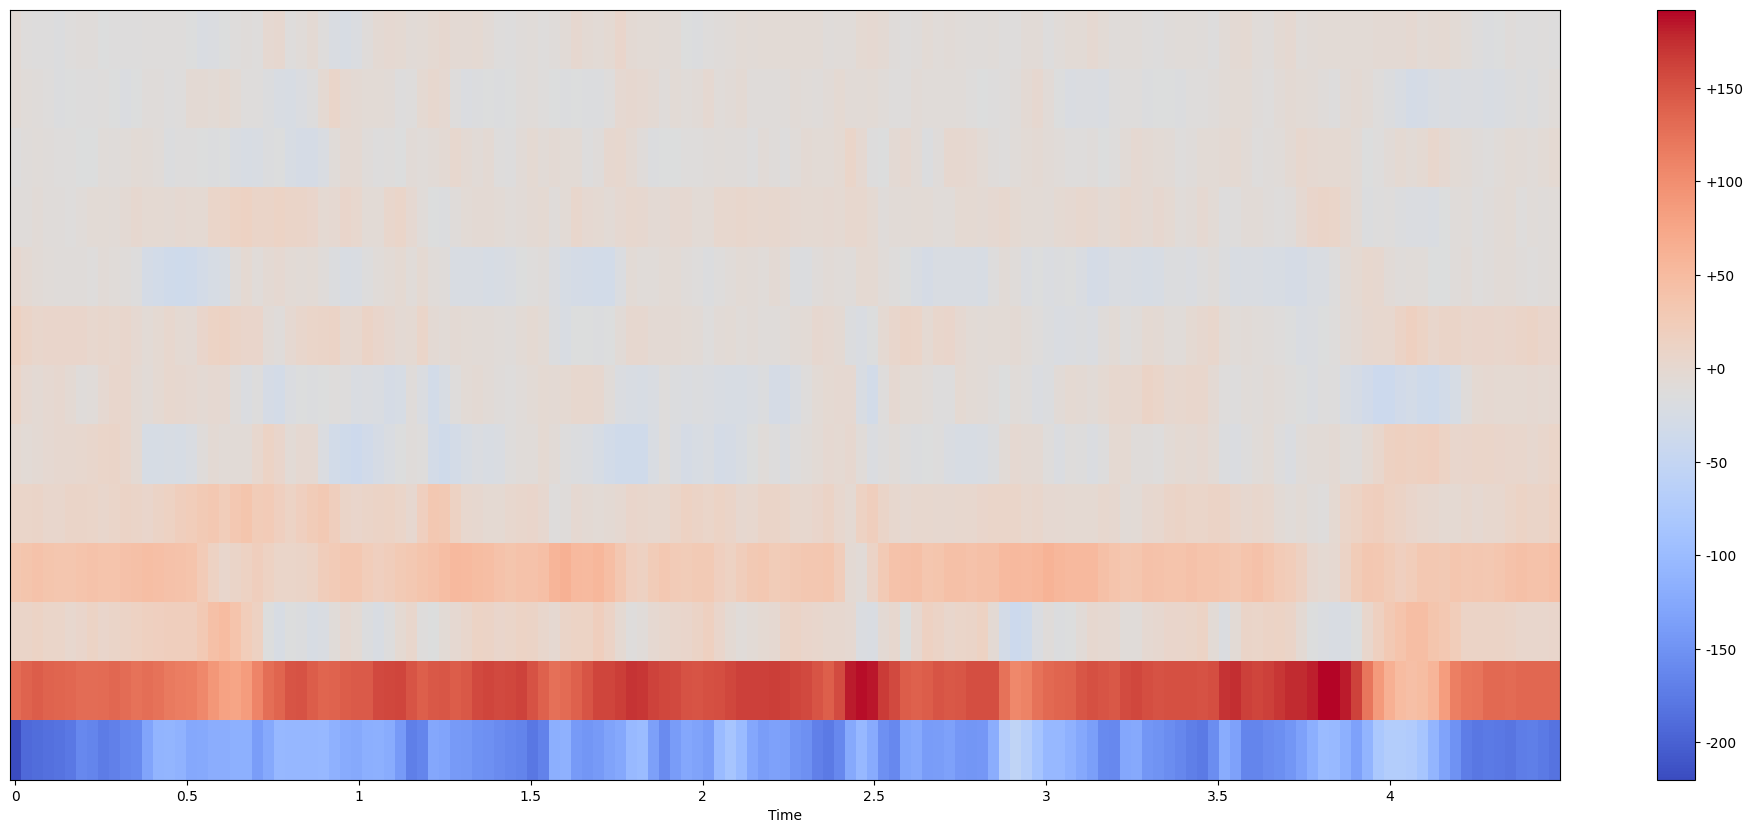

In [7]:
import h5py
import numpy as np

# Path to the HDF5 file
hdf5_path = "D:/University/Data/sample/mfcc_hdf5/mfcc_batch_0.hdf5"

# Open the HDF5 file
with h5py.File(hdf5_path, 'r') as hdf5_file:
    # List all groups (which correspond to all audio files in this case)
    print("Datasets in the HDF5 file:")
    print(list(hdf5_file.keys()))

    # Extract the MFCCs for a specific file
    audio_filename = "281474976879627_f1171_chunk_0.wav"  # replace with an actual file name from your HDF5 file
    if audio_filename in hdf5_file:
        mfccs = np.array(hdf5_file[audio_filename])
        print(f"MFCCs for {audio_filename}:")
        print(mfccs)
    else:
        print(f"Dataset for {audio_filename} not found in the HDF5 file.")

    plt.figure(figsize=(25,10))
    librosa.display.specshow(mfccs, x_axis="time", sr=16000)

    plt.colorbar(format="%+2.f")
    plt.show()


## Checking

Check if mfcc was successful. The test was done with sample data in the trimmed folder. The sample folder included 1000 files so once we perform mfcc and store data in HDF5 files with each file including data about 100 files (thus total 10 files). We can check my getting all the keys from each batch file (keys are file names) and then check if the file names are present in the original folder. If they are we can add this ket to another set. If the final length of the new set is 1000, that means we encountered all files. Since we are using set, we can be sure none of the file were duplicates.

In [2]:
import os
import h5py

def get_audio_file_list(audio_dir):
    """Get a list of audio file names from the directory."""
    return [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

def check_hdf5_files(audio_file_list, hdf5_dir):
    count = 0
    hdf5_files = [f for f in os.listdir(hdf5_dir) if f.endswith('.hdf5')]

    found_files = set()  # To track found files

    for hdf5_file in hdf5_files:
        with h5py.File(os.path.join(hdf5_dir, hdf5_file), 'r') as file:
            file_keys = set(file.keys())
            for audio_file in audio_file_list:
                if audio_file in file_keys:
                    found_files.add(audio_file)

    return len(found_files)

# Your existing code for directories and calling the function


# Directory containing your audio files and HDF5 files
audio_dir = "D:/University/Data/sample/trimmed"
hdf5_dir = "D:/University/Data/sample/mfcc_hdf5"

# Get the list of audio files and check them in HDF5 files
audio_file_list = get_audio_file_list(audio_dir)
matched_count= check_hdf5_files(audio_file_list, hdf5_dir)

print(f"Total audio files matched in HDF5 files: {matched_count}")


Total audio files matched in HDF5 files: 1000


In [4]:
#check for the actual data
hdf5_dir = "D:/University/Data/mfcc/mfcc_cmvn_delta"
total = 0

hdf5_files = [f for f in os.listdir(hdf5_dir) if f.endswith('.hdf5')]
for hdf5_file in hdf5_files:
        with h5py.File(os.path.join(hdf5_dir, hdf5_file), 'r') as file:
            file_keys = set(file.keys())
            print(f"Total number of keys in {hdf5_file}")
            total += len(file_keys)

print(f"Total audio files: {total}")


Total number of keys in mfcc_batch_0.hdf5
Total number of keys in mfcc_batch_1.hdf5
Total number of keys in mfcc_batch_10.hdf5
Total number of keys in mfcc_batch_100.hdf5
Total number of keys in mfcc_batch_101.hdf5
Total number of keys in mfcc_batch_102.hdf5
Total number of keys in mfcc_batch_103.hdf5
Total number of keys in mfcc_batch_104.hdf5
Total number of keys in mfcc_batch_105.hdf5
Total number of keys in mfcc_batch_106.hdf5
Total number of keys in mfcc_batch_107.hdf5
Total number of keys in mfcc_batch_108.hdf5
Total number of keys in mfcc_batch_109.hdf5
Total number of keys in mfcc_batch_11.hdf5
Total number of keys in mfcc_batch_110.hdf5
Total number of keys in mfcc_batch_111.hdf5
Total number of keys in mfcc_batch_112.hdf5
Total number of keys in mfcc_batch_12.hdf5
Total number of keys in mfcc_batch_13.hdf5
Total number of keys in mfcc_batch_14.hdf5
Total number of keys in mfcc_batch_15.hdf5
Total number of keys in mfcc_batch_16.hdf5
Total number of keys in mfcc_batch_17.hdf5
